In [52]:
import pandas as pd
import numpy as np
import torch
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from safetensors.numpy import load_file
from scipy.special import softmax
from sklearn.metrics import pairwise
from tqdm import tqdm

from ece_bin import ECE_bin
from CV_pipeline import ECE_bin_CV
from experiments import TCE_experiments, CCE_experiments, unpickle_probs

k_folds_val = 10

In [53]:
# breast and pneumonia have very few data instances,
# so we would need a different evaluation with more CV folds
settings_vit = [
    ('Derma', 'ViT', 'logits/derma_vit_base_patch16_224.orig_in21k_ft_in1k_output.safetensors'),
    ('OCT', 'ViT', 'logits/oct_vit_base_patch16_224.orig_in21k_ft_in1k_output.safetensors'),
    ('Blood', 'ViT', 'logits/blood_vit_base_patch16_224.orig_in21k_ft_in1k_output.safetensors'),
]

In [54]:
exp_results = TCE_experiments(
    settings_vit, k_folds_val=k_folds_val, k_folds_test=1,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:11<00:00, 23.70s/it]


In [55]:
filename = 'results/real_data/TCE_binning_krr_kkrr_kde_vit.pkl'
with open(filename, 'wb') as file:
    pickle.dump(exp_results, file)

In [56]:
filename = 'results/real_data/TCE_binning_krr_kkrr_kde_vit.pkl'
with open(filename, 'rb') as file:
    exp_results = pickle.load(file)
exp_results = pd.DataFrame(exp_results)
exp_results['TCE estimate'] = exp_results['ECE estimate']**.5
exp_results['RMSE'] = exp_results['Val Risk']**.5
exp_results['Estimator'] = exp_results['Type'].replace({
    '15 bins': 'TCE$_2^{15-bins}$',
    'Opt bins': 'TCE$_2^{bins}$',
    'Opt KKRR': 'TCE$_2^{ukkr}$',
    'Opt KRR': 'TCE$_2^{kkr}$',
    'Opt KDE': 'TCE$_2^{kde}$',
})

In [57]:
std_results = []
for index, result in exp_results.iterrows():
    pd_results = pd.DataFrame(result['CV results'])
    pd_results['val_risk'] = pd_results['val_risk']**.5
    pd_results['avg_pred_test'] = pd_results['avg_pred_test']**.5
    if result['Type']=='15 bins':
        val_risk = pd_results[pd_results['n_bins']==15]['val_risk'].mean()
        val_risk_std = pd_results[pd_results['n_bins']==15]['val_risk'].std()
        test_ece_est = pd_results[pd_results['n_bins']==15]['avg_pred_test'].mean()
        test_ece_est_std = pd_results[pd_results['n_bins']==15]['avg_pred_test'].std()
    else:
        if result['Type']=='Opt bins':
            grp_results = pd_results.groupby(['n_bins']).mean()
            grp_results_std = pd_results.groupby(['n_bins']).std()
        elif result['Type']=='Opt KKRR':
            grp_results = pd_results.groupby(['reg_const']).mean()
            grp_results_std = pd_results.groupby(['reg_const']).std()
        elif result['Type']=='Opt KRR':
            grp_results = pd_results.groupby(['reg_const']).mean()
            grp_results_std = pd_results.groupby(['reg_const']).std()
        elif result['Type']=='Opt KDE':
            pd_results['bandwidth'] = torch.Tensor(pd_results['bandwidth'].values.tolist()).numpy()
            grp_results = pd_results.groupby(['bandwidth']).mean()
            grp_results_std = pd_results.groupby(['bandwidth']).std()
        optim = grp_results['val_risk'].argmin()
        val_risk = grp_results.iloc[optim]['val_risk'].item()
        val_risk_std = grp_results_std.iloc[optim]['val_risk'].item()
        test_ece_est = grp_results.iloc[optim]['avg_pred_test'].item()
        test_ece_est_std = grp_results_std.iloc[optim]['avg_pred_test'].item()
        
    std_results += [{
        'Dataset': result['Dataset'],
        'Model': result['Model'],
        'TCE estimate': test_ece_est,
        'TCE estimate STD': test_ece_est_std,
        'Acc': result['Acc'],
        'Type': result['Type'],
        'RMSE': val_risk,
        'RMSE STD': val_risk_std,
        'Runtime': result['Runtime'] if 'Runtime' in result.keys() else None,
    }]

std_results = pd.DataFrame(std_results)
std_results['Estimator'] = std_results['Type'].replace({
    '15 bins': 'TCE$_2^{15-bins}$',
    'Opt bins': 'TCE$_2^{bins}$',
    'Opt KKRR': 'TCE$_2^{ukkr}$',
    'Opt KRR': 'TCE$_2^{kkr}$',
    'Opt KDE': 'TCE$_2^{kde}$',
})

/tmp/ipykernel_1515129/3993630063.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)


<Figure size 600x400 with 0 Axes>

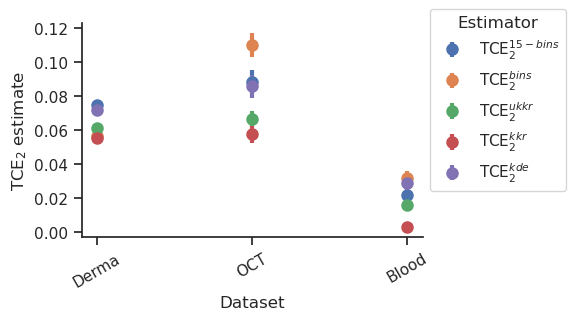

In [58]:
colors = {
    'TCE$_2^{15-bins}$':'tab:blue',
    'TCE$_2^{bins}$':'tab:orange',
    'TCE$_2^{ukkr}$':'tab:green',
    'TCE$_2^{kkr}$':'tab:red',
    'TCE$_2^{kde}$':'tab:purple'
}
dot_size = 8
sns.set(font_scale=1)
sns.set_style('ticks')
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(data=std_results, hue='Estimator', aspect=1.5)
g.map(plt.errorbar, 'Dataset', 'TCE estimate', 'TCE estimate STD', fmt='o', elinewidth=3, markersize=dot_size)
g.set(ylabel='TCE$_2$ estimate')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=30)
plt.legend(loc="upper left",bbox_to_anchor=(1,1.1), title='Estimator')
g.savefig("Plots/TCE_ViT_binning_krr_kkrr_kde.png", bbox_inches='tight', dpi=1000);

In [59]:
n_signif_digs = 2
std_results.loc[:,'RMSE'] = np.round(std_results['RMSE']*100, n_signif_digs)
std_results.loc[:,'RMSE STE'] = np.round(std_results['RMSE STD']*100/(k_folds_val**.5), n_signif_digs)
result_table = pd.pivot_table(
    std_results[['Dataset', 'RMSE', 'Estimator']],
    values='RMSE',
    index=['Estimator'],
    columns=['Dataset'],
    aggfunc="sum"
)
result_table_std = pd.pivot_table(
    std_results[['Dataset', 'RMSE STE', 'Estimator']],
    values='RMSE STE',
    index=['Estimator'],
    columns=['Dataset'],
    aggfunc="sum"
)
result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
#columns_titles = ['LeNet-5', 'Densenet-40', 'ResNetWide-32', 'Resnet-110',
#       'Resnet-110 SD']
#result_table=result_table.reindex(columns=columns_titles)
print(result_table.to_latex())

\begin{tabular}{llll}
\toprule
Dataset & Blood & Derma & OCT \\
Estimator &  &  &  \\
\midrule
TCE$_2^{15-bins}$ & 0.54 $\pm$ 0.12 & 6.0 $\pm$ 0.42 & 5.9 $\pm$ 0.94 \\
TCE$_2^{bins}$ & 0.52 $\pm$ 0.12 & 6.0 $\pm$ 0.42 & 5.87 $\pm$ 0.93 \\
TCE$_2^{kde}$ & 0.96 $\pm$ 0.23 & 7.78 $\pm$ 0.58 & 5.96 $\pm$ 0.95 \\
TCE$_2^{kkr}$ & 0.52 $\pm$ 0.12 & 5.99 $\pm$ 0.41 & 5.87 $\pm$ 0.94 \\
TCE$_2^{ukkr}$ & 0.52 $\pm$ 0.12 & 5.99 $\pm$ 0.42 & 5.87 $\pm$ 0.94 \\
\bottomrule
\end{tabular}



<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1515129/1074489362.py:18: SyntaxWarning: invalid escape sequence '\p'
  result_table = result_table.astype(str) + " $\pm$ " + result_table_std.astype(str)
